In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForImageClassification, AutoImageProcessor
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.image_utils import show_mask_on_image
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

import cv2

In [286]:
image_processor = AutoImageProcessor.from_pretrained(
    "akahana/vit-base-cats-vs-dogs",
    cache_dir = '/Data'
)
model = AutoModelForImageClassification.from_pretrained(
    "akahana/vit-base-cats-vs-dogs",
    attn_implementation = 'eager',
    cache_dir = '/Data'
)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [287]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [288]:
dataset = load_dataset(
    "microsoft/cats_vs_dogs",
    cache_dir='/Data',
    split = 'train'
)

In [289]:
idx = np.random.randint(0, 23_000)
image = dataset[idx]['image']
c = dataset[idx]
tokens = image_processor(image, return_tensors = 'pt')

In [291]:
metric = AttentionRollout(model, attention_layer_name='attention', is_vit=True, head_fusion='mean', discard_ratio=0.)

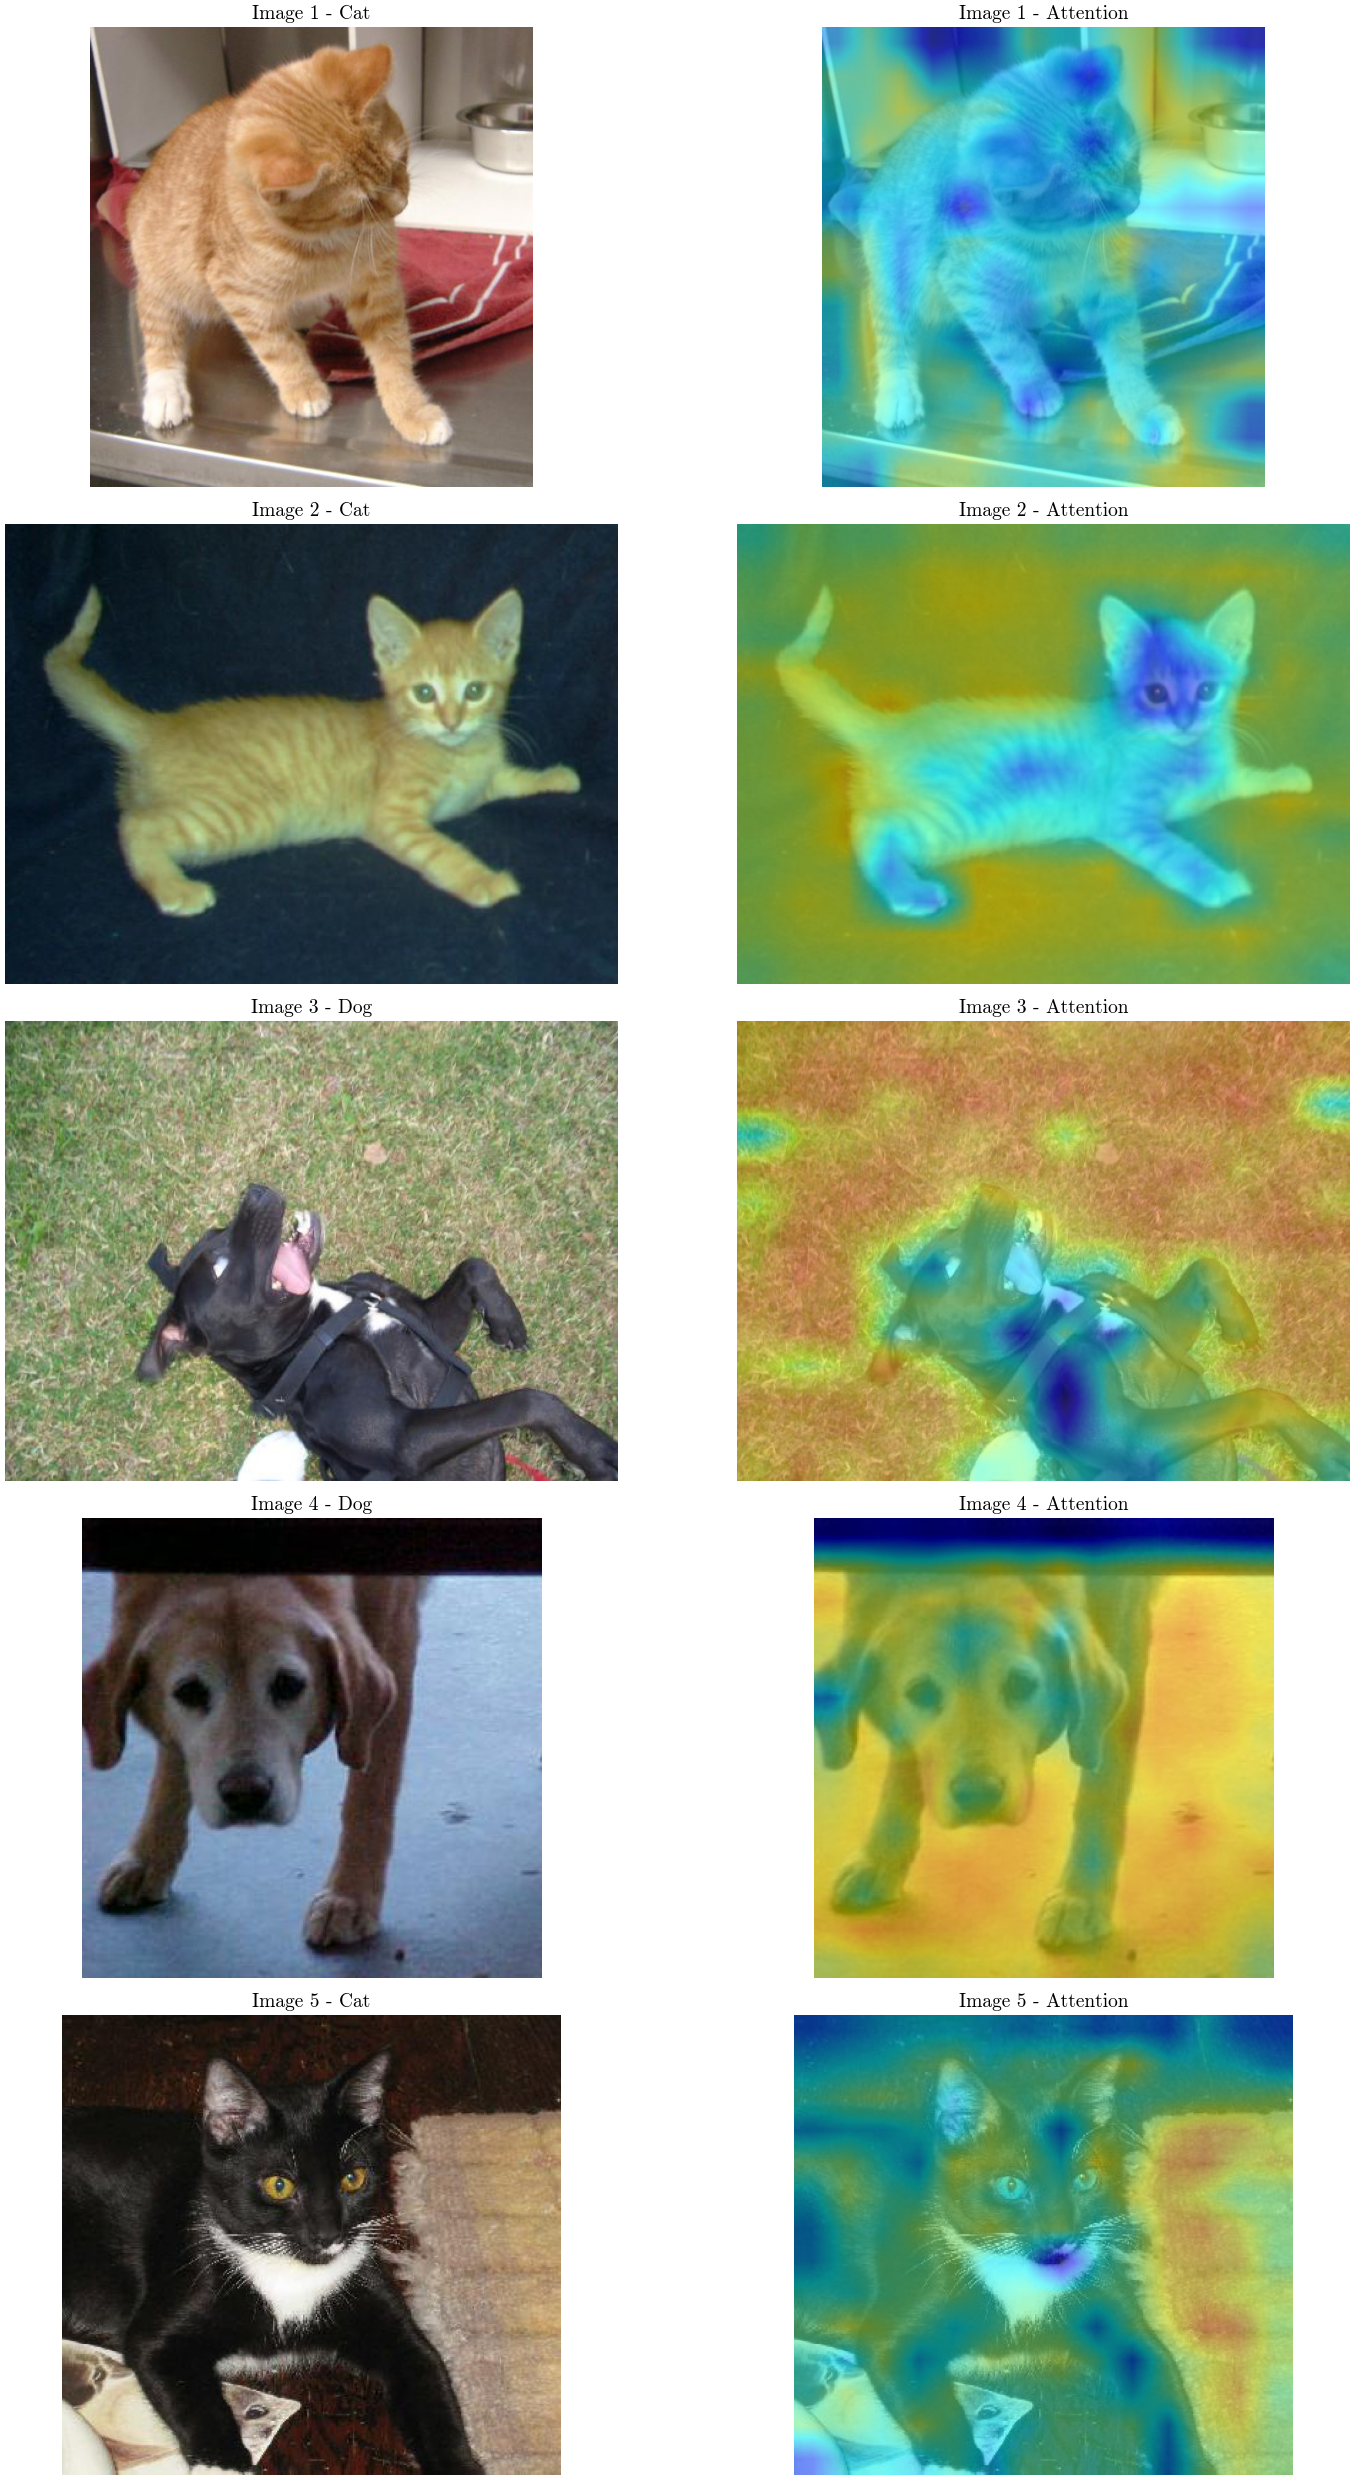

In [296]:
num_images = 5
fig, axes = plt.subplots(num_images, 2, figsize=(16, 5 * num_images))

for i in range(num_images):
    # Select a random index from dataset
    idx = np.random.randint(0, 23000)
    image = dataset[idx]['image']
    label = dataset[idx]['labels']  # Get class label (0: Cat, 1: Dog)

    # Process image tokens
    tokens = image_processor(images=image, return_tensors='pt')

    # Perform inference and attention rollout
    metric = AttentionRollout(model, attention_layer_name='attention', is_vit=True, head_fusion='mean', discard_ratio=0.)
    with torch.no_grad():
        outputs = metric(**tokens, output_attentions=True)

    attention = outputs[1]

    # Convert image to NumPy format for visualization
    np_img = np.array(image)[:, :, ::-1]
    mask = cv2.resize(attention, (np_img.shape[1], np_img.shape[0]))
    img_focus = show_mask_on_image(np_img, mask)

    # Get the class label (0 for cats, 1 for dogs)
    class_label = "Dog" if label == 1 else "Cat"

    # Display original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Image {i+1} - {class_label}", fontsize=14)
    axes[i, 0].axis("off")

    # Display attention map
    axes[i, 1].imshow(img_focus)
    axes[i, 1].set_title(f"Image {i+1} - Attention", fontsize=14)
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()